In [1]:
import pandas as pd # Manejo de bases de datos
import geopandas as gpd # Manejo de bases de datos geográficas
import numpy as np # Funciones numéricas
import matplotlib.pyplot as plt # Gráficas
import seaborn as sns # Gráficas
import datetime as dt
import folium
import unicodedata
import datetime as dt

from geopandas.tools import sjoin
from unicodedata import normalize
from sklearn.cluster import KMeans

### Bogotá spatial characteristics by UTAM Previously prepared

In [2]:
# Load files
path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/partial_spatial_utam.pkl'
spatial_utam = pd.read_pickle(path, compression='gzip')
spatial_utam = gpd.GeoDataFrame(spatial_utam)
spatial_utam.crs = 'EPSG:4326'
spatial_utam.to_crs(epsg=4326, inplace=True)

### Estimate utams population weight vector

In [3]:
# Function to standarize accent marks and lowercases 
def Arreglar_tilde(Texto):
    Texto = unicodedata.normalize('NFD', Texto)
    Texto = Texto.encode('ascii', 'ignore')
    Texto = Texto.decode("utf-8")
    Texto = Texto.lower()
    return(Texto)

# Bogotá localities population formatting and cleaning
path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Files/Poblacion_Bogota.xlsx'
PobBog = pd.read_excel(path, sheet_name='1.1')
PobBog = PobBog.drop([PobBog.index[0], PobBog.index[1], PobBog.index[2], PobBog.index[3], PobBog.index[4], 
                      PobBog.index[25], PobBog.index[26]])

PobBog = PobBog.filter(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 17', 'Unnamed: 18'])
PobBog = PobBog.rename(columns={'Unnamed: 0': 'id localidad', 'Unnamed: 1': 'localidad',
                                     'Unnamed: 17': 'Población 2020', 'Unnamed: 18': 'Población 2021'})

PobBog['id localidad'] = pd.to_numeric(PobBog['id localidad'])
PobBog.sort_values(by='id localidad', ascending=True)
PobBog.drop(columns={'Población 2020'}, inplace=True)
PobBog.reset_index(drop=True, inplace=True)
PobBog['localidad'] = PobBog.apply(lambda row: Arreglar_tilde(row['localidad']), axis=1)
pop_list = PobBog['Población 2021'].tolist()

# Localities codes are ascending numbers from 1 to 19
Loc_code = list(range(1,20))

# Estimate population weight vector with number of homes in each UTAM and localities population
LocHomes = []
for i in range(len(Loc_code)):
    temp = spatial_utam[ spatial_utam['LOCid'] == Loc_code[i] ]
    temp_list = temp['HOGARES'].values.tolist()
    tot_homes = sum(temp_list)
    LocHomes.append(tot_homes)
    
ppl_weight = []
for i in range(len(LocHomes)):
    temp = pop_list[i]/LocHomes[i]
    ppl_weight.append(temp)
    
del Arreglar_tilde, LocHomes, PobBog

### Estimated Rt for every locality 

In [4]:
# Reading localities R_t
base_path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/'

loc_R_list = ['usaquen.pkl', 'chapinero.pkl', 'santafe.pkl', 'sancristobal.pkl', 'usme.pkl',
             'tunjuelito.pkl', 'bosa.pkl', 'kennedy.pkl', 'fontibon.pkl', 'engativa.pkl',
             'suba.pkl', 'barriosunidos.pkl', 'teusaquillo.pkl', 'losmartires.pkl', 'antonionariño.pkl',
             'puentearanda.pkl', 'lacandelaria.pkl', 'rafaeluribeuribe.pkl', 'ciudadbolivar.pkl']

R_list = []
# Load data frames, reset index
for i in range(len(loc_R_list)):
    path_file = base_path+loc_R_list[i]
    R_list.append(pd.read_pickle(path_file))
    
for i in range(len(loc_R_list)):
    R_list[i].reset_index(drop=False, inplace=True)
    
# Create DF containing all RT scores for each locality 
R_df = pd.DataFrame(index = R_list[0]['Time Stamp'])
R_df.reset_index(drop=False, inplace=True)

for i in range(len(loc_R_list)):
    R_df[loc_R_list[i]] = 0
    R_df[loc_R_list[i]] = R_list[i]['R'].tolist()

### Active Cases Count

In [5]:
# Load file
fechas_df = pd.read_csv('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/fechas_sintomas.csv')
fechas_df = fechas_df.rename(columns={'LOCALIDAD_ASIS': 'CASOS_REPORTADOS'})#Rename Column

#Change str to datetime objects
fechas_df['FECHA_DE_INICIO_DE_SINTOMAS'] = pd.to_datetime(fechas_df['FECHA_DE_INICIO_DE_SINTOMAS'], format='%Y-%m-%d')
fechas_df = fechas_df.sort_values(by='FECHA_DE_INICIO_DE_SINTOMAS', ascending=True)
fechas_df = fechas_df.reset_index(drop=True)

#Drop 0 and 21 id codes since they don´t belong to Bogotá geography 
index_0 = fechas_df[ fechas_df['CODIGO_LOCALIDAD'] == 0 ].index
index_21 = fechas_df[ fechas_df['CODIGO_LOCALIDAD'] == 21 ].index

fechas_df.drop(index_0, inplace = True)#drop fuera de bogotá and sin dato rows since we cannot calculate infection 
fechas_df.drop(index_21, inplace = True)# density for them (we don´t know their reference population)

fechas_df = fechas_df.reset_index(drop = True)

com_index = len(fechas_df['FECHA_DE_INICIO_DE_SINTOMAS']) #column length 
start_date = fechas_df.loc[0, 'FECHA_DE_INICIO_DE_SINTOMAS'] #start of the pandemic in Bogotá 
end_date = fechas_df.loc[com_index-1, 'FECHA_DE_INICIO_DE_SINTOMAS'] #Last reported date 

pan_days = end_date - start_date
pan_days = int(pan_days.days) #Days passed since pandemic start to last reported date grid x axis 
local_bog = 20 # number of rows y axis we are not considering 0 and 21 codes 

#create grid and fill it with reported cases y axis correspond to Bogota localities id code, x axis correspond to 
#number of days passed since pandemic started that way 0 index -> 2020-02-06, 1->2020-02-07 and so on

grid = np.ndarray([local_bog, pan_days+1]) #create grid
grid.fill(0) #fill grid with 0 

#Method used to fill grid with reported cases 
def fillGrid(date, code, cases):
    col = date - start_date
    col = int(col.days)
    grid[code-1][col] = cases
    

#Fill grid with cases 
fechas_df.apply(lambda row: fillGrid(row['FECHA_DE_INICIO_DE_SINTOMAS'], row['CODIGO_LOCALIDAD'], int(row['CASOS_REPORTADOS']) ), axis=1)
#function used to count active cases in certain date
def ActiveCases (date, code):
    col = date - start_date
    col = int(col.days)
    if col >= 15:
        Active = sum(grid[code-1][col-15:col+1])
    else: 
        Active = sum(grid[code-1][0:col+1])
    return int(Active)

### Functions

In [8]:
# used to granulate cases
def single_cases(weight, caseLoc, PobLoc, ID, Hog):
    x = (100*caseLoc)/(PobLoc)
    y = (x*weight[ID-1]*Hog)/100
    return y

#used to granulate RT
def singularizeRT(loc, estrato, popden, hosp, ips, itur, sitp, comer, trips, cases, RT):
    if loc == 'candelaria':
        return RT
    else:
        a_rt = RT-estrato+popden-hosp-ips+itur+sitp+comer+trips+cases
        return a_rt

# take base DataFrame and selected date and estimate RT, active cases and prepare a new DF 
# to perform clustering 
def ClusteringPrepDF(selec_date, selec_str, spatial_utam):
    #Add Active cases in interest date at locality level
    Active_cases = []
    for i in range(len(Loc_code)):
        Active_cases.append(ActiveCases(selec_date, Loc_code[i]))
        
    #Add Active Cases
    spatial_utam_date = spatial_utam.copy()    
    spatial_utam_date['cases'+selec_str] = spatial_utam_date.apply(lambda row: Active_cases[row['LOCid']-1], axis=1)
    #Estimate Active cases in a lower geographical level
    spatial_utam_date['UTAM_cases'+selec_str] = spatial_utam_date.apply(lambda row: single_cases(ppl_weight, 
                                                                                                  row['cases'+selec_str], 
                                                                                                  row['PopLoc'], row['LOCid'], 
                                                                                                  row['HOGARES']), axis=1)
    #Locality RT in interest date
    rt_list = R_df[ R_df['Time Stamp'] == selec_date ]
    rt_list = rt_list.iloc[:, 1:].values.tolist()[0]
    #Add RT to DataFrame
    spatial_utam_date['Rt'+selec_str] = spatial_utam_date.apply(lambda row: rt_list[row['LOCid']-1], axis=1)
    #Estimate RT in a lower geographical level
    spatial_utam_date['Total trips'] = spatial_utam_date['originated Trips']+spatial_utam_date['received Trips']
    spatial_utam_date.drop(columns={'HOGARES', 'UTAMArea', 'originated Trips', 'received Trips',
                               'N_PlazMer', 'N_Col'}, inplace=True)
    
    spatial_utam_date_rt = spatial_utam_date.copy()
    spatial_utam_date_rt['ESTRATOPre'] = spatial_utam_date_rt['ESTRATOPre']/(spatial_utam_date_rt['ESTRATOPre'].max()*4)
    spatial_utam_date_rt['PopDen[p/km2]'] = spatial_utam_date_rt['PopDen[p/km2]']/(spatial_utam_date_rt['PopDen[p/km2]'].max()*4)
    spatial_utam_date_rt['N_Hosp'] = spatial_utam_date_rt['N_Hosp']/(spatial_utam_date_rt['N_Hosp'].max()*4)
    spatial_utam_date_rt['N_IPS'] = spatial_utam_date_rt['N_IPS']/(spatial_utam_date_rt['N_IPS'].max()*4)
    spatial_utam_date_rt['N_ITur']  = spatial_utam_date_rt['N_ITur']/(spatial_utam_date_rt['N_ITur'].max()*4)
    spatial_utam_date_rt['N_SITP'] = spatial_utam_date_rt['N_SITP']/(spatial_utam_date_rt['N_SITP'].max()*4)
    spatial_utam_date_rt['N_Ecomer'] = spatial_utam_date_rt['N_Ecomer']/(spatial_utam_date_rt['N_Ecomer'].max()*4)
    spatial_utam_date_rt['Total trips'] = spatial_utam_date_rt['Total trips']/(spatial_utam_date_rt['Total trips'].max()*4)
    spatial_utam_date_rt['UTAM_cases'+selec_str] = spatial_utam_date_rt['UTAM_cases'+selec_str]/(spatial_utam_date_rt['UTAM_cases'+selec_str].max()*3)
    
    spatial_utam_date_rt['singleRT_'+selec_str] = spatial_utam_date_rt.apply(lambda row: singularizeRT(row['LOCNombre'], row['ESTRATOPre'], 
                                                                                       row['PopDen[p/km2]'], row['N_Hosp'],
                                                                                       row['N_IPS'], row['N_ITur'],
                                                                                       row['N_SITP'], row['N_Ecomer'],
                                                                                       row['Total trips'], 
                                                                                       row['UTAM_cases'+selec_str],
                                                                                       row['Rt'+selec_str]), axis=1)
    
    # Finally generate final normalized DF with an estimated rt for each utam 
    spatial_utam_date['local_rt_'+selec_str] = spatial_utam_date_rt['singleRT_'+selec_str]

    spatial_utam_date['ESTRATOPre'] = spatial_utam_date['ESTRATOPre']/(spatial_utam_date['ESTRATOPre'].max())
    spatial_utam_date['PopDen[p/km2]'] = spatial_utam_date['PopDen[p/km2]']/(spatial_utam_date['PopDen[p/km2]'].max())
    spatial_utam_date['N_Hosp'] = spatial_utam_date['N_Hosp']/(spatial_utam_date['N_Hosp'].max())
    spatial_utam_date['N_IPS'] = spatial_utam_date['N_IPS']/(spatial_utam_date['N_IPS'].max())
    spatial_utam_date['N_ITur']  = spatial_utam_date['N_ITur']/(spatial_utam_date['N_ITur'].max())
    spatial_utam_date['N_SITP'] = spatial_utam_date['N_SITP']/(spatial_utam_date['N_SITP'].max())
    spatial_utam_date['N_Ecomer'] = spatial_utam_date['N_Ecomer']/(spatial_utam_date['N_Ecomer'].max())
    spatial_utam_date['Total trips'] = spatial_utam_date['Total trips']/(spatial_utam_date['Total trips'].max())
    spatial_utam_date['UTAM_cases'+selec_str] = spatial_utam_date['UTAM_cases'+selec_str]/(spatial_utam_date['UTAM_cases'+selec_str].max())
    spatial_utam_date['local_rt_'+selec_str] = spatial_utam_date['local_rt_'+selec_str]/(spatial_utam_date['local_rt_'+selec_str].max())
    
    spatial_utam_date.drop(columns={'Rt'+selec_str, 'cases'+selec_str}, inplace=True)
    spatial_utam_date = spatial_utam_date[ ['LOCNombre', 'PopLoc', 'UTAM', 'LOCid', 'ESTRATOPre', 'UTAMNombre',
                                       'PopDen[p/km2]', 'geometry', 'N_Hosp', 'N_IPS', 'N_ITur', 'N_SITP',
                                       'N_Ecomer', 'UTAM_cases'+selec_str, 'local_rt_'+selec_str ,'Total trips'] ]
    return spatial_utam_date

In [9]:
# Used to stratify risk
def StratRisk(Cluster):
    if Cluster == 0:
        return 0
    elif Cluster == 1:
        return 2
    elif Cluster == 2:
        return 1

### Train Clustering

In [10]:
# Cluster Training data is an specific date corresponding to a contagion peak in Bogotá
selec_date = '10/01/2021'
selec_str = '10-01-2021'
selec_date = dt.datetime.strptime(selec_date, "%d/%m/%Y")
# Prepare DF to perform clustering 
TrainDF = ClusteringPrepDF(selec_date, selec_str, spatial_utam)
TrainDF_mat = TrainDF.drop(columns={'LOCNombre', 'PopLoc','UTAM', 'LOCid', 'UTAMNombre', 'geometry', 
                                     'ESTRATOPre', 'PopDen[p/km2]', 'N_Hosp', 'N_IPS', 'N_ITur', 'N_SITP', 
                                     'N_Ecomer', 'Total trips'})
# get matrix from dataframe
TrainMat = TrainDF_mat.to_numpy()

# Cluster characteristics
n_clust = 3
# Train Cluster Kmeans
global_kmeans = KMeans(n_clusters=n_clust, random_state=10).fit(TrainMat)

### Stratify Community Risk

In [11]:
#peak and valley dates from Bogotá epidemic curve
date_list = ['01/05/2020' ,'01/07/2020', '01/09/2020', '01/11/2020', '01/01/2021', '01/03/2021', 
             '01/05/2021', '01/06/2021', '01/07/2021', '01/09/2021']

date_list2 = ['01-05-2020' ,'01-07-2020', '01-09-2020', '01-11-2020', '01-01-2021', '01-03-2021', 
             '01-05-2021', '01-06-2021', '01-07-2021', '01-09-2021']

# Predict Cluster labels
o = 5 # Select date
selec_date = date_list[o]
selec_str = date_list2[o]
#format date
selec_date = dt.datetime.strptime(selec_date, "%d/%m/%Y")
#Prepare DF 
RiskDF = ClusteringPrepDF(selec_date, selec_str, spatial_utam)
RiskDFmat = RiskDF.drop(columns={'LOCNombre', 'PopLoc','UTAM', 'LOCid', 'UTAMNombre', 'geometry', 
                                     'ESTRATOPre', 'PopDen[p/km2]', 'N_Hosp', 'N_IPS', 'N_ITur', 'N_SITP', 
                                     'N_Ecomer', 'Total trips'})
#Get matrix
RiskMat = RiskDFmat.to_numpy()
#Predict Cluster labels and stratify risk
labels = global_kmeans.predict(RiskMat)
RiskDF['kmeans_label_full'] = labels
RiskDF['Risk'] = RiskDF.apply(lambda row: StratRisk(row['kmeans_label_full']), axis=1)

In [15]:
# Optionally save Risk Stratified DataFrame
#RiskDF.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Bog_Estimation/reg_ml/ClustDFs/Labeled/date_'+selec_str+'.pkl')

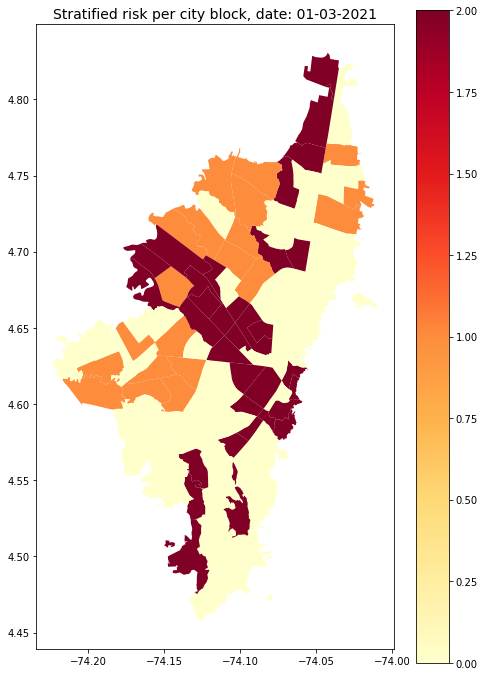

In [12]:
# Plot risk stratification map
RiskDF.plot(column='Risk', cmap='YlOrRd', figsize=(8,12), legend=True);
plt.title('Stratified risk per city block, date: '+selec_str, fontsize=14);
name = 'Cluster_'+date_list2[o]
plt.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_3/Outputs/'+name)